In [ ]:
!pip install konlpy
!pip install googletrans==3.1.0a0

In [ ]:
import pandas as pd
import re
import konlpy
import wordcloud
import os
import gensim
from konlpy.tag import Komoran
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
translator = Translator()
komoran = Komoran(userdic = "/content/drive/MyDrive/graduation/komoran_dict.txt") #기본사전 + 사용자사전
stopwords_path = "/content/drive/MyDrive/graduation/stopwords.txt" 

with open(stopwords_path, encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [w.strip() for w in stopwords] #불용어사전

In [ ]:
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/graduation/all_flip.csv', encoding='cp949')

In [ ]:
#1. 이상치 제거

In [ ]:
#이상치 기준 설정 함수
'''
1. 띄어쓰기 없앰
2. 알파벳, 중국어(한자), 일본어(히라가나, 가타가나), 아랍어, 그리고 한국어 음절을 '제외'한 다른 숫자/기호/글자 제거
3. 그 상태에서 문자열의 길이(글자 개수) 측정
'''

def outlier(text):
  text = re.sub(r'[^a-zA-Z가-힇ぁ-ゔァ-ヴー々〆〤一-龥\u0600-\u06FF]','',text)
  length = len(text)
  return length


In [ ]:
outlier('나는 abc 靑年 カメラ')

10

In [ ]:
df['length'] = df['REPLY'].apply(lambda x: outlier(str(x)))

In [ ]:
df

,REPLY,length
0,와 진짜 매번 볼때마다 느끼는거지만 기업쪽에 잘보이려는거 단 1도 없이 장단점 솔직...,103
1,삼성폰 리뷰하면서 LG 카톡 광고가 ㅋㅋ정말 순간 센스 넘칩니다 ^_^b,26
2,"와.. 저도 플립 사용중인데 쓰면서 좋은 점, 개선되었음 하는 점 명확히 정리해주셔...",97
3,아이폰 쓰다가 플립으로 넘어왔는데 일단 사용하면서 너무 만족했어요. 물론 배터리가 ...,121
4,진짜 딱 배터리가 크리티컬한 단점이긴 한데 저번에 잇섭님 분해영상 보니까 나름 위쪽...,85
...,...,...
9998,순간 개그만 박성호씨가 여장하신줄 알았네요;;,19
9999,여자가쓰면진짜이쁜데 남자가쓰면 보기좋지도않음 너무여성스러움,29
10000,아무리봐도 선글라스가 안어울리네.보면서 계속 거슬려요.,24
10001,그렇게. 똑똑하면. 댁들이 만들지. 돈버는. 방법도. 가지가지네이걸 만든사람 노고...,38


In [ ]:
df['length'].describe()

count    10003.000000
mean        34.633710
std         43.114056
min          0.000000
25%         12.000000
50%         22.000000
75%         41.000000
max        679.000000
Name: length, dtype: float64

In [ ]:
print(df['length'].skew()) #왼쪽으로 너무 치우침

4.847489001636717


In [ ]:
print(df['length'].kurtosis()) #너무 뾰족함

38.77147664866325


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


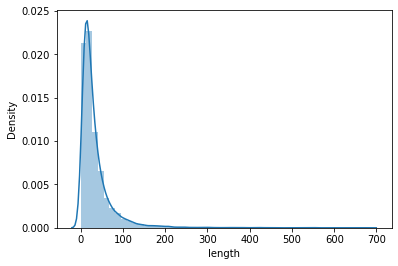

In [ ]:
sns.distplot(df['length']) #정규분포를 이루지 않고 왼쪽으로 너무 치우쳐 있음 -> 데이터 정규화 과정이 필요함

In [ ]:
df['log_length'] = np.log1p(df['length']) #데이터를 로그변환함 -> log(x+1)

In [ ]:
df['log_length'].describe()

count    10003.000000
mean         3.153706
std          0.906787
min          0.000000
25%          2.564949
50%          3.135494
75%          3.737670
max          6.522093
Name: log_length, dtype: float64

In [ ]:
print(df['log_length'].skew()) #거의 대칭을 이룸

-0.0456078890987966


In [ ]:
print(df['log_length'].kurtosis()) # 전보다는 정규분포 모양에 가까운 뾰족함

0.7019578778580038


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


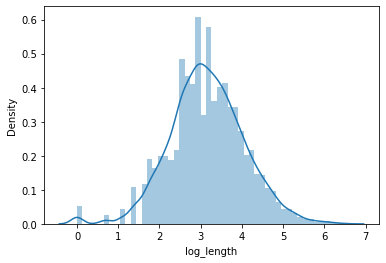

In [ ]:
sns.distplot(df['log_length']) #그래프상으로도 정규분포 모양과 가까워짐을 확인

In [ ]:
q1, q3 =np.percentile(df['log_length'],[25,75])

q1 #제1사분위수

q3 #제3사분위수

iqr = q3-q1 #사분위수 범위

lower_bound = q1 - (iqr*1.5) #이상치 기준점
lower_bound #정보가 적은 댓글만 제거할 것이므로 lower_bound만 필요함.



0.8058689662287892

In [ ]:
outlier_df = df[df['log_length']<=lower_bound]

In [ ]:
outlier_df.sample(5)

,REPLY,length,log_length
9955,4:32 허!!!!!!!!!!!!!!,1,0.693147
5297,ㅇㅇㅃ,0,0.000000
7852,ㅇㅈ,0,0.000000
9211,ㅋㅋ,0,0.000000
1793,ㅈㅎㄷ,0,0.000000


In [ ]:
new_df = df[df['log_length']>lower_bound] #lower_bound보다 낮은 수치의 데이터를 삭제

In [ ]:
new_df.index = [i for i in range(len(new_df))]
new_df #이상치를 제거한 데이터

,REPLY,length,log_length
0,와 진짜 매번 볼때마다 느끼는거지만 기업쪽에 잘보이려는거 단 1도 없이 장단점 솔직...,103,4.644391
1,삼성폰 리뷰하면서 LG 카톡 광고가 ㅋㅋ정말 순간 센스 넘칩니다 ^_^b,26,3.295837
2,"와.. 저도 플립 사용중인데 쓰면서 좋은 점, 개선되었음 하는 점 명확히 정리해주셔...",97,4.584967
3,아이폰 쓰다가 플립으로 넘어왔는데 일단 사용하면서 너무 만족했어요. 물론 배터리가 ...,121,4.804021
4,진짜 딱 배터리가 크리티컬한 단점이긴 한데 저번에 잇섭님 분해영상 보니까 나름 위쪽...,85,4.454347
...,...,...,...
9893,순간 개그만 박성호씨가 여장하신줄 알았네요;;,19,2.995732
9894,여자가쓰면진짜이쁜데 남자가쓰면 보기좋지도않음 너무여성스러움,29,3.401197
9895,아무리봐도 선글라스가 안어울리네.보면서 계속 거슬려요.,24,3.218876
9896,그렇게. 똑똑하면. 댁들이 만들지. 돈버는. 방법도. 가지가지네이걸 만든사람 노고...,38,3.663562


In [ ]:
new_df.to_csv('/content/drive/MyDrive/graduation/new_df_flip.csv', index=False)

In [ ]:
#___________________________________________________________________